# building a reading map based on a reduced graph of co-edited pages

The drawing of the graph of pages linked when their share editors is very messy. It also show a non-pertinent structure to achieve our goal. On an another hand, the hyperlink graph is also not very pertinent because it is more about semantical and logical relationships between content that the after effect of intelligence shaping a knowledge landscape.

When trying to read a knowledge map for learning, it is important to keep the number of paths/edges in a low order scope. In that order, we propose here a strategy to reduce the number of edges while keeping a socio-semantical logic and reducing the influence of strong attractors like "Pi" or "mathematics".

## importing original graphs

In [1]:
%run "libraries.ipynb"

In [15]:
import networkx as nx

In order to achieve our goal, we are going to start with the initial bi-partite graph composed by pages and editors.

In [44]:
# list of pages
pages = map(lambda x: x.strip(), codecs.open("data/pagenames.txt","r", "utf-8-sig").readlines())

# pages-editors bi-partite graph
pages_editors_graph = nx.read_gexf("data/pages-editors.gexf")

# pages graph projection from pages-editors bi-partite graph
pages_graph = nx.read_gexf("data/pages-linked-by-coeditors.gexf")

## reducing the graph

The main strategy we are going to use is not to go with computing out-degrees but only keep in-degrees. Big pages like "Pi" or "mathematics" tend to attract more co-editors and will overpower the other pages and break the logicality of the paths we propose by being to central.

The main hypothesis we propose here is that in a setting of recommanding the 3 next pages a user need to read a particular page $p_i$ are the 3 pages that rank $p_i$ at their top.

The implemented below is pretty straighforward:
- for a page $p_i$
    - take all its neighbors $p_{ij}$
        - compute the number of co-editors between $p_i$ and $p_{ij}$
        - rank $p_i$ in the neighborhood of $p_{ij}$
    - keep the 3 pages which rank $p_i$ as highest

In [46]:
g = nx.DiGraph()

for p in pages:
    #print p
    #print "==========="
    # calculate rank in neighbor top co-edited ranking
    nb = sorted(pages_graph["p:%s" % (p)].items(),
        key=lambda (k,x): -int(x["coeditors"]))
    
    for name, info in nb:
        nb_mirror = sorted(pages_graph[name].items(),
                key=lambda (k,x): -int(x["coeditors"]))
        nb_mirror = [ x[0] for x in nb_mirror ]
        
        editors = pages_editors_graph[name]        
        info["editors"] = len(editors)
        info["exclusive editors"] = len([n for n in editors if len(pages_editors_graph[n]) == 1 ])
        info["ranking"] = nb_mirror.index("p:%s" % (p)) + 1
    
    # get the 3 pages to which the current page are in top ranking
    nb2 = sorted(nb, key=lambda (x): x[1]["ranking"])
    for name, info in nb2[0:3]:
        #print name
        g.add_edge(p, name.split(":")[1])

    #print ""

In [56]:
print "reduced graph"
print "============="
print "nodes: %s" % (len(g.nodes()))
print "edges: %s" % (len(g.edges()))
print "reduction: %s/%s (%s)" % (len(g.edges()),
                                 len(pages_editors_graph.edges()),
                                 float(len(g.edges()))/float(len(pages_editors_graph.edges())))

reduced graph
nodes: 303
edges: 909
reduction: 909/39927 (0.0227665489518)


With only 303 nodes, edges are the main source of noise. Our method demonstrate that while keeping all node connected we also reduce drastically the number of edges by keeping only 2% of them.

## partitions

In the following section, we are going to use the [Louvain partitioning method](https://perso.uclouvain.be/vincent.blondel/research/louvain.html) in order to check if the reduced graph structure also keep important information and therefore provide use more readibility about our data.

All the muscle are done by Thomas Aynaud the [implentation of into a python library](http://perso.crans.org/aynaud/communities/).

In [59]:
import community
partitions = community.best_partition(g.to_undirected())

In [60]:
def print_groups(communities):
    for c, ps in communities.iteritems():
        print "group %s:" % (c)
        print "---------"

        for p in ps:
            print p

        print ""

communities = {}
for k, v in partitions.iteritems():
    communities.setdefault(v, []).append(k)

#print communities

print print_groups(communities)

group 0:
---------
Discrete geometry
Polygon triangulation
Heronian tetrahedron
Point in polygon
Convex hull
Mathematical morphology
Digital geometry
Geometry of numbers
Minkowski's theorem
Parallelepiped
Coordinate-free
Image analysis
Zonohedron
Polytope
Delaunay triangulation
Lattice (group)
Symmetry
Voronoi diagram
Polyhedron
Dissection problem
Taxicab geometry
Computational geometry
Heronian triangle
Angular defect
Hilbert's third problem
Minkowski addition
Pythagorean triple
Graham scan
Convex geometry
Point location

group 1:
---------
Triangle inequality
Integral geometry
Invariant (mathematics)
Point (geometry)
Klein geometry
Polar sine
Root system
Noncommutative geometry
Pappus's centroid theorem
Parametric surface
Contact geometry
Group action
Parabolic geometry (differential geometry)
Riemannian geometry
Analytic geometry
Dividing a circle into areas
Systolic geometry
Line (geometry)
Central angle
Oval (projective plane)
N-sphere
Strähle construction
Affine space
Euclidean d

The partition given by the louvain partitioning system is not that helpfull but it also isolate the big generalist/abstract nodes into the group 7. 

In [51]:
nx.write_gexf(g, "data/reading_maps/pages-coedited-reduced-3.gexf")

### adjacency matrix

We are going to plot an adjacency matrix combined with partitions in order to visualy check the pertinence of the underlying structure. It gives a preview of the possibilty to draw a map with a find colouring to differientiate the different group of nodes but also apply a spacialization that will separate them geometricaly.

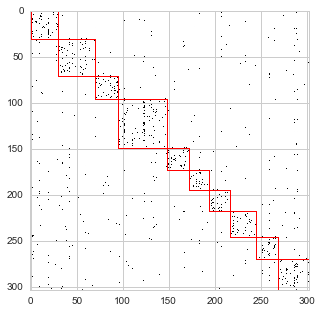

In [74]:
from matplotlib import patches

ordered_nodes = [ n for c, ps in communities.iteritems() for n in ps ]
adjacency_matrix = nx.to_numpy_matrix(g, nodelist=ordered_nodes)

fig = plt.figure(figsize=(5, 5)) # in inches

plt.imshow(adjacency_matrix, cmap="Greys", interpolation="none")

ax = plt.gca()

#print communities
idx = 0
for i,c in communities.iteritems():
    m = len(c)
    ax.add_patch(patches.Rectangle((idx, idx),
                                   m, # Width
                                   m, # Height
                                   facecolor="none",
                                   edgecolor="red",
                                   linewidth="1"))
    idx += m

## rending with force atlas 2 and sigma.js

This is not working yet but you can check the [pdf rendering](https://github.com/WeKeyPedia/notebooks/blob/master/geometry/renderings/geometry-reading_map-reduced3.pdf).

In [99]:
%%html
<div id="graph_container"></div>

In [108]:
%%javascript

require.config({paths: {sigma: "/javascript/sigma.js"}});
// require.config({paths: {sigmagexf: "https://raw.githubusercontent.com/jacomyal/sigma.js/master/plugins/sigma.parsers.gexf/sigma.parsers.gexf.js"}});

require(["sigma"], function(sigma){
    console.log(sigma);
});

<IPython.core.display.Javascript object>